In [7]:
%matplotlib ipympl
import time
import traceback
from onix.data_tools import get_experiment_data
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools
from tqdm import tqdm
from onix.analysis.t_violation import TViolation
from uncertainties import ufloat
from onix.units import ureg

<h2>Datapoints from optical spectrum</h2>

In [68]:
check_data_numbers = range(210663, 211309)
data_not_allowed = range(211803, 211874)
data_list = [data_number for data_number in check_data_numbers if data_number not in data_not_allowed ] # TEMP
use_data_numbers = []

for data_number in tqdm(data_list):
    _, headers = get_experiment_data(data_number)
    # print(headers["params"]["rf"]["probe_detuning"])
    if np.isclose(headers["params"]["rf"]["probe_detuning"].to("kHz").magnitude, -167.8):
        use_data_numbers.append(data_number)
        # print(headers["params"]["rf"]["probe_detuning"].to("kHz").magnitude)
print(use_data_numbers)


100%|████████████████████████████████████████████████████████████████████████████████| 646/646 [00:11<00:00, 54.42it/s]

[210675, 210699, 210723, 210747, 210771, 210795, 210819, 210843, 210867, 210891, 210915, 210939, 210962, 210986, 211010, 211034, 211058, 211082, 211106, 211130, 211154, 211178, 211202, 211226]


In [69]:
print(len(use_data_numbers))

24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 50.67it/s]


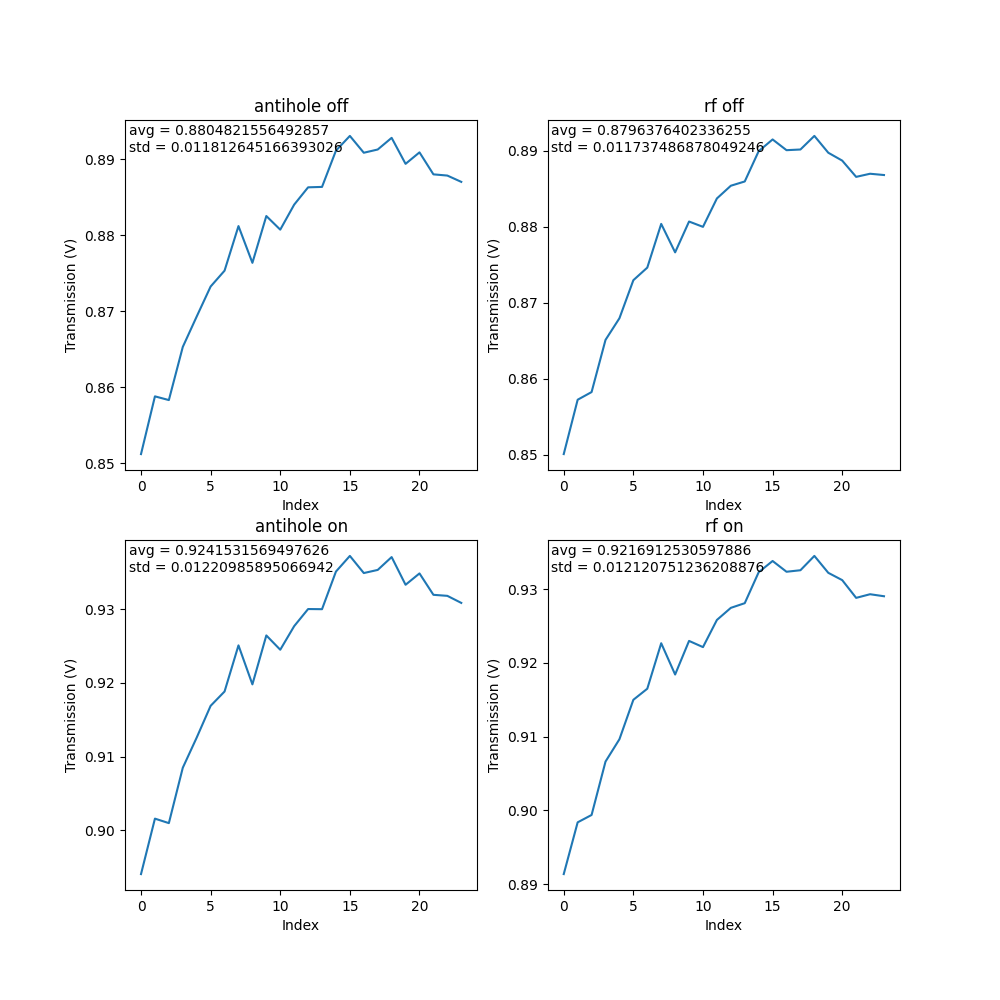

In [73]:
data_on_off_resonance = [[], [], [], []]

for data_number in tqdm(use_data_numbers):
    data, headers = get_experiment_data(data_number)
    detunings_MHz = headers["detunings"].to("MHz").magnitude
    transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])

    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    
    mask = detunings_MHz < 0
    data_on_off_resonance[0].append(antihole_avg[mask][0])
    data_on_off_resonance[1].append(rf_avg[mask][0])
    
    mask = detunings_MHz == 0
    data_on_off_resonance[2].append(antihole_avg[mask][0])
    data_on_off_resonance[3].append(rf_avg[mask][0])

titles = ["antihole off", "rf off", "antihole on", "rf on"]
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axs.ravel()):
    ax.plot(data_on_off_resonance[i])
    ax.set_title(titles[i])
    ax.set_xlabel("Index")
    ax.set_ylabel("Transmission (V)")
    ax.text(.01, .99, f"avg = {np.average(data_on_off_resonance[i])}", ha='left', va='top', transform=ax.transAxes)
    ax.text(.01, .94, f"std = {np.std(data_on_off_resonance[i])}", ha='left', va='top', transform=ax.transAxes)
plt.show()
# fig, ax = plt.subplots()
# ax.scatter(detunings_MHz[mask], antihole_avg[mask], label="antihole", color="C1")
# ax.scatter(detunings_MHz[mask], rf_avg[mask], label="rf", color="C2")

# ax.set_xlabel("Optical detuning (MHz)")
# ax.set_ylabel("Transmission (V)")
# plt.legend()
# plt.tight_layout()
# plt.show()

<h2>Allan deviation</h2>

100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 159.23it/s]


-0.04251457865180286 -0.04173629025951997
0.889653976975309


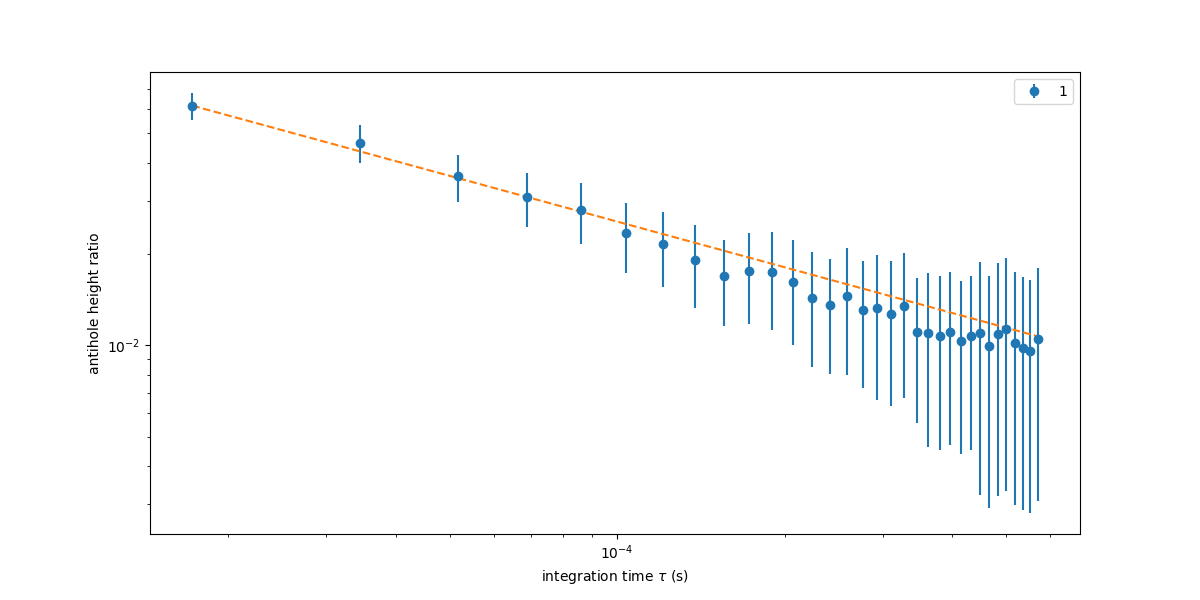

In [71]:
data_groups = {
    "0": (210687, 211309)
}

first_integration_times = []
on_times = []
allan_first = []
allan_first_errs = []

fig, ax = plt.subplots(figsize=(12, 6))
for ll in range(1):
    allans = []
    allan_errs = []
    for kk in tqdm(use_data_numbers):
        data, headers = get_experiment_data(kk)
        transmissions_avg = data["transmissions_avg"]
        fitter = Fitter(lambda x, a, b: a * x + b)
        
        cycle_time = ((headers["params"]["detect"]["on_time"] * 2 + headers["params"]["detect"]["off_time"] * 2.5 + headers["params"]["detect"]["delay"]).to("s").magnitude) + 4e-6
        # print(headers["params"]["detect"]["on_time"])
        cycles = headers["params"]["detect"]["cycles"]["antihole"]
        
        factor = 1
        times = np.arange(cycles*factor) * cycle_time
        ah_ratios = transmissions_avg[:cycles*factor,2] / transmissions_avg[:cycles*factor,3]
        rf_ratios = transmissions_avg[cycles*factor:cycles*factor*2,2] / transmissions_avg[cycles*factor:cycles*factor*2,3]
        ratios = (1-rf_ratios) / (1-ah_ratios + 1e-18)
        fitter.set_data(times, ratios)
        fitter.fit()
        
        ratios_no_bg = ratios - fitter.fitted_value(times) + fitter.results["b"]
        plot_variable = np.copy(ratios)
        
        plot_variable /= np.average(plot_variable)
        # print(np.std(plot_variable))
        taus = np.logspace(0, np.log10(len(plot_variable) // 3), 200)
        real_taus, allan, allan_err, _ = allantools.adev(plot_variable, data_type="freq", taus=taus)
        real_taus *= cycle_time
        allans.append(allan)
        allan_errs.append(allan_err)
        # print(kk)
    print(1- np.average(ah_ratios), 1- np.average(rf_ratios))
    print(np.average(transmissions_avg))
        
    allan2 = np.average(allans, axis=0)
    allan_err2 = np.average(allan_errs, axis=0)/np.sqrt(len(data_group))
    first_integration_times.append(real_taus[0])
    allan_first.append(allan2[0])
    allan_first_errs.append(allan_err2[0])
    on_times.append(headers["params"]["detect"]["on_time"].to("us").magnitude)
    ax.errorbar(real_taus, allan2, allan_err2, fmt="o", label=label)
            
    ax.plot(real_taus, allan2[0] / np.sqrt(real_taus / real_taus[0]), ls="--")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("integration time $\\tau$ (s)")
    ax.set_ylabel("antihole height ratio")
plt.legend()
plt.show()

In [51]:
print(transmissions_avg)

[[0.956498   0.91753326 0.91462788 0.87916434]
 [0.96262721 0.92303632 0.9193565  0.88391462]
 [0.94240851 0.89962521 0.89853387 0.86090262]
 ...
 [0.91305381 0.87242663 0.8705091  0.83698382]
 [0.91758326 0.87740841 0.87538549 0.84094587]
 [0.92162443 0.88607871 0.88140548 0.8461077 ]]
